In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib widget
import os
from scipy.signal import savgol_filter

In [69]:
def smooth_pv_data(pressure, window_len = 100):
    # window_len = 100
    poly_order = 2
    len_pressure, num_exp = np.shape(pressure)

    pressure_smooth = np.zeros((len_pressure, num_exp))

    for i in range(num_exp):
        pressure_smooth[:,i] = savgol_filter(pressure[:,i], window_len, poly_order)
    
    return pressure_smooth

def rescale_eigenvalue(eigenvalues_cur):
    return np.sign(eigenvalues_cur) * np.sqrt(np.abs(eigenvalues_cur)) * 1/(2*np.pi)

def highlight_mode(freq_all, initial_i, initial_j, num_samp, num_pts = 2, select_fac = 1):
    j_all = np.zeros(np.shape(freq_all)[0], dtype = int)
    i_all = np.arange(np.shape(freq_all)[0], dtype = int)
    j_all[initial_i] = initial_j
    cut_idx = initial_i[0] + np.arange(num_samp + 2)

    for idx in range(0, num_samp, select_fac):
        i_next = idx + initial_i[1] + select_fac #min value 2

        if idx <= select_fac * (num_pts - 2): num_pts_temp = 2
        else: num_pts_temp = num_pts

        if idx == 0: i_cur = [i_next - select_fac - 1, i_next - select_fac]
        else: i_cur = [i_next - select_fac * (num_pts_temp - i) for i in range(num_pts_temp)]
        j_cur = [j_all[i] for i in i_cur]
        
        vals_cur = np.array([freq_all[i,j] for i,j in zip(i_cur, j_cur)])

        if idx == 0: val_new_est = vals_cur[-1] + select_fac * np.mean(np.diff(vals_cur))
        else: val_new_est = vals_cur[-1] + np.mean(np.diff(vals_cur))

        j_all[i_next] = np.argmin(np.abs(freq_all[i_next,:] - val_new_est))

        if select_fac > 1:
            j_all[i_cur[-1] + 1:i_next] = int(np.mean([j_all[i_cur[-1]], j_all[i_next]]))
    return (i_all, j_all, cut_idx)

In [3]:
data_all = np.loadtxt('exp_results/PV_Benders.csv', skiprows = 2, delimiter = ',', usecols = tuple(range(4)))
vol_all = data_all[:,0]
pressure_bend = np.mean(data_all[:,1:], axis = 1)


#note: checked and this is averaged correctly w/o any extra volume stuff

R = 10 #mm
H = 18 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL

vol_bend = vol_all / vol_0

pressure_bend_smooth = smooth_pv_data(data_all[:,1:], 300)
pressure_bend_smooth_mean = np.mean(pressure_bend_smooth, axis = 1)
pressure_bend_smooth_std = np.std(pressure_bend_smooth, axis = 1)


### bending angle ###
data_ba = np.loadtxt('exp_results/BetaV_Benders.csv', skiprows = 1, delimiter = ',')
vol_bend_ba = data_ba[:,0]
ba_bend = np.mean(data_ba[:,1:], axis = 1)

ba_smooth = smooth_pv_data(data_ba[:,1:])
ba_smooth_mean = np.mean(ba_smooth, axis = 1)
ba_smooth_std = np.std(ba_smooth, axis = 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


frame: 9: V_bar = 0.04482
frame 9: [ 48.22794862  69.06038897  90.99564696 128.10270663 139.07524669
 168.41894594 172.68769715 211.38892198 218.15964626 227.72106081]


array([0.03486, 0.03984, 0.04482])

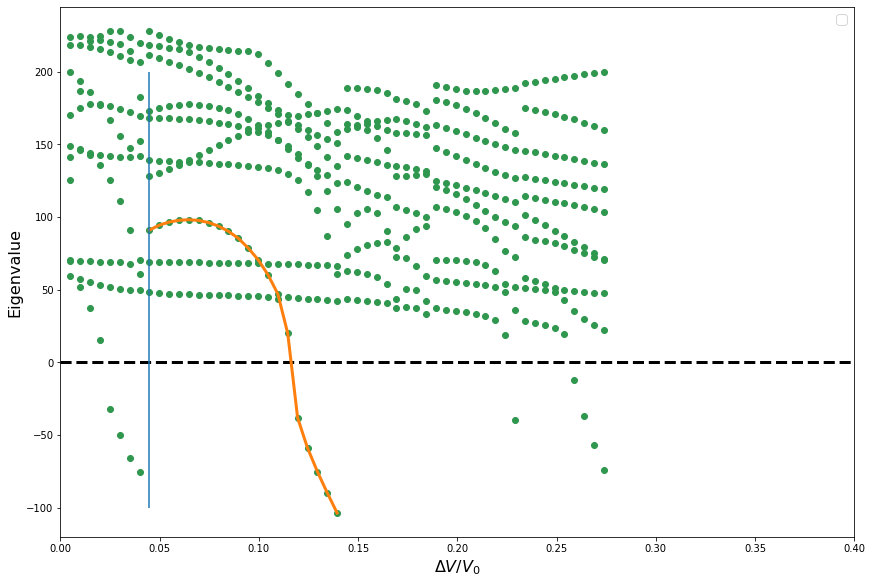

In [76]:
damping_sweep = 2*np.logspace(-8, -4, 5)

# fig, ax = plt.subplots(figsize = (14,10))
fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)

initial_idx = 150

cmap_all = ['Blues', 'Reds','Greens', 'Oranges', 'Purples', 'Greys', 'BuGn', 'YlOrBr', 'PuRd', 'YlGn']

ax.hlines(0,0,0.55, 'k', '--', linewidth = 3)

for i,stab_fac in enumerate(damping_sweep):
    if i ==2:
        idx_cur = initial_idx + i
        data_path = f'data_out/bender-static-stable-v{idx_cur}_eig_val.txt'
        data_cur = np.loadtxt(data_path)
        temp_all = data_cur[:,0]
        freq_all = data_cur[:,1:]

        color_plot = plt.get_cmap(cmap_all[i])(0.7)
        vol_plot = -3 * temp_all

        for j in range(np.shape(freq_all)[1]):
            freq_rescale = np.sign(freq_all[:,j]) * np.sqrt(np.abs(freq_all[:,j])) * 1/(2*np.pi)
            # freq_rescale = freq_all[:,j]
            ax.plot(-3*temp_all, freq_rescale, 'o', color = color_plot)
            # if j == 0:
            #     ax.plot(-3*temp_all, freq_rescale, '-', color = color_plot, label = rf'$f$ = {stab_fac:.2e}')
            # else:
            #     ax.plot(-3*temp_all, freq_rescale, '-', color = color_plot)

i_all, j_all, cut_idx = highlight_mode(freq_all, [8, 9], [2], 18)
mode_plot = rescale_eigenvalue(freq_all[i_all[cut_idx],j_all[cut_idx]])
ax.plot(vol_plot[i_all[cut_idx]], mode_plot, linewidth = 3, color = 'tab:orange')

ax.legend(loc = 'best', fontsize = 14)
ax.set_xlabel('$\Delta V/V_0$', fontsize = 16)
ax.set_ylabel('Eigenvalue', fontsize = 16)
ax.set_xlim(0,0.4)


frame_sp = 9
idx_sp = frame_sp - 1
ax.vlines(-3*temp_all[idx_sp], -100,200)
print(f'frame: {frame_sp}: V_bar = {-3*temp_all[idx_sp]:.5f}')
print(f'frame {frame_sp}: {rescale_eigenvalue(freq_all[idx_sp,:])}')
-3*temp_all[6:9]


# print(np.diff(-3*temp_all[6:9]))
# ax.set_ylim(0,60e3)
# ax.set_ylim(0,80)

#bender-static-stable-v200_multi_buckling
#data_out/bender-static-stable-v200_eig_val.txt

(0.0, 0.4)

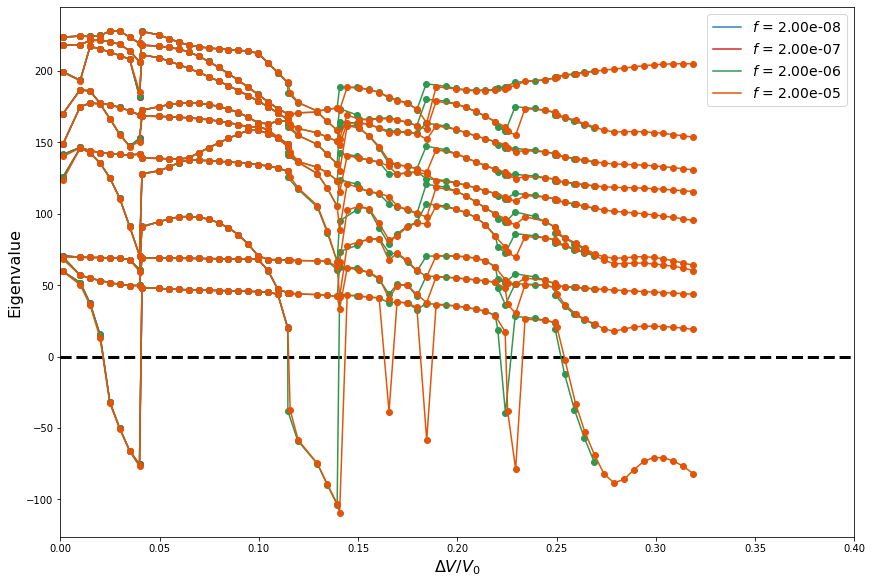

In [27]:
damping_sweep = 2*np.logspace(-8, -4, 5)

# fig, ax = plt.subplots(figsize = (14,10))
fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)

initial_idx = 150

cmap_all = ['Blues', 'Reds','Greens', 'Oranges', 'Purples', 'Greys', 'BuGn', 'YlOrBr', 'PuRd', 'YlGn']

ax.hlines(0,0,0.55, 'k', '--', linewidth = 3)

for i,stab_fac in enumerate(damping_sweep):
    if i < 4:
        idx_cur = initial_idx + i
        data_path = f'data_out/bender-static-stable-v{idx_cur}_eig_val.txt'
        data_cur = np.loadtxt(data_path)
        temp_all = data_cur[:,0]
        freq_all = data_cur[:,1:]

        color_plot = plt.get_cmap(cmap_all[i])(0.7)

        for j in range(np.shape(freq_all)[1]):
            freq_rescale = np.sign(freq_all[:,j]) * np.sqrt(np.abs(freq_all[:,j])) * 1/(2*np.pi)
            # freq_rescale = freq_all[:,j]
            ax.plot(-3*temp_all, freq_rescale, 'o', color = color_plot)
            if j == 0:
                ax.plot(-3*temp_all, freq_rescale, '-', color = color_plot, label = rf'$f$ = {stab_fac:.2e}')
            else:
                ax.plot(-3*temp_all, freq_rescale, '-', color = color_plot)



ax.legend(loc = 'best', fontsize = 14)
ax.set_xlabel('$\Delta V/V_0$', fontsize = 16)
ax.set_ylabel('Eigenvalue', fontsize = 16)
ax.set_xlim(0,0.4)
# ax.set_xlim(0.17,0.25)
# ax.set_ylim(0,60e3)
# ax.set_ylim(0,80)

#bender-static-stable-v200_multi_buckling
#data_out/bender-static-stable-v200_eig_val.txt

5652.14892578125


(-3.0, 0.0)

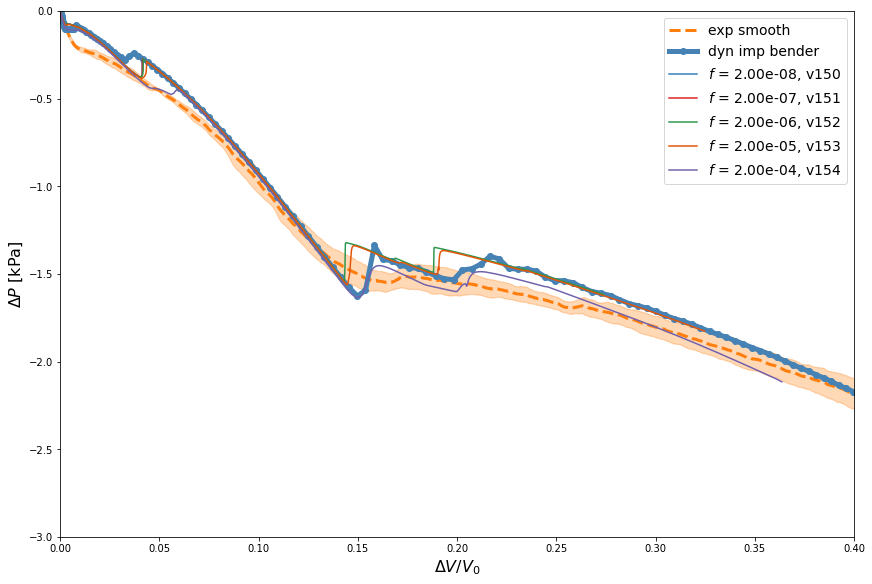

In [26]:
damping_sweep = 2*np.logspace(-8, -4, 5)

# fig, ax = plt.subplots(figsize = (14,10))
fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)

ax.plot(vol_bend, pressure_bend_smooth_mean, '--', linewidth = 3, color = 'tab:orange', label = 'exp smooth')
ax.fill_between(vol_bend, pressure_bend_smooth_mean - pressure_bend_smooth_std, pressure_bend_smooth_mean + pressure_bend_smooth_std, color = 'tab:orange', alpha = 0.3)

idx_cur = 141
data_cur = np.loadtxt(f'data_out/bender-dyn-imp-v{idx_cur}_pcav_cvol.txt')
# data_cur = np.loadtxt(f'data_out/4fold-fitting-{idx_cur}_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3
print(data_cur[0,0])

ax.plot(vol_norm,pressure_kpa, '-o', label = 'dyn imp bender', color = 'steelblue', linewidth = 5)

initial_idx = 150

cmap_all = ['Blues', 'Reds','Greens', 'Oranges', 'Purples', 'Greys', 'BuGn', 'YlOrBr', 'PuRd', 'YlGn']

# ax.hlines(0,0,0.55, 'k', '--', linewidth = 3)

for i,stab_fac in enumerate(damping_sweep):
    if i >= 0:
        idx_cur = initial_idx + i
        data_path = f'data_out/bender-static-stable-v{idx_cur}_pcav_cvol.txt'
        cvol, pcav = np.loadtxt(data_path, unpack = True)


        color_plot = plt.get_cmap(cmap_all[i])(0.7)

        

        ax.plot(-(cvol - cvol[0])/cvol[0], pcav*1e3, color = color_plot, label = f'$f$ = {stab_fac:.2e}, v{idx_cur}')

        # for j in range(np.shape(freq_all)[1]):
        #     freq_rescale = np.sign(freq_all[:,j]) * np.sqrt(np.abs(freq_all[:,j])) * 1/(2*np.pi)
        #     # freq_rescale = freq_all[:,j]
        #     ax.plot(-3*temp_all, freq_rescale, 'o', color = color_plot)
        #     if j == 0:
        #         ax.plot(-3*temp_all, freq_rescale, '-', color = color_plot, label = rf'$f$ = {stab_fac:.2e}')
        #     else:
        #         ax.plot(-3*temp_all, freq_rescale, '-', color = color_plot)



ax.legend(loc = 'best', fontsize = 14)
ax.set_xlabel('$\Delta V/V_0$', fontsize = 16)
ax.set_ylabel('$\Delta P$ [kPa]', fontsize = 16)
ax.set_xlim(0,0.4)
# ax.set_xlim(0.17,0.25)
# ax.set_ylim(0,60e3)
ax.set_ylim(top = 0, bottom = -3)

#bender-static-stable-v200_multi_buckling
#data_out/bender-static-stable-v200_eig_val.txt

5652.14892578125
5652.14892578125
[0.03723582 0.15386786 0.40315419]


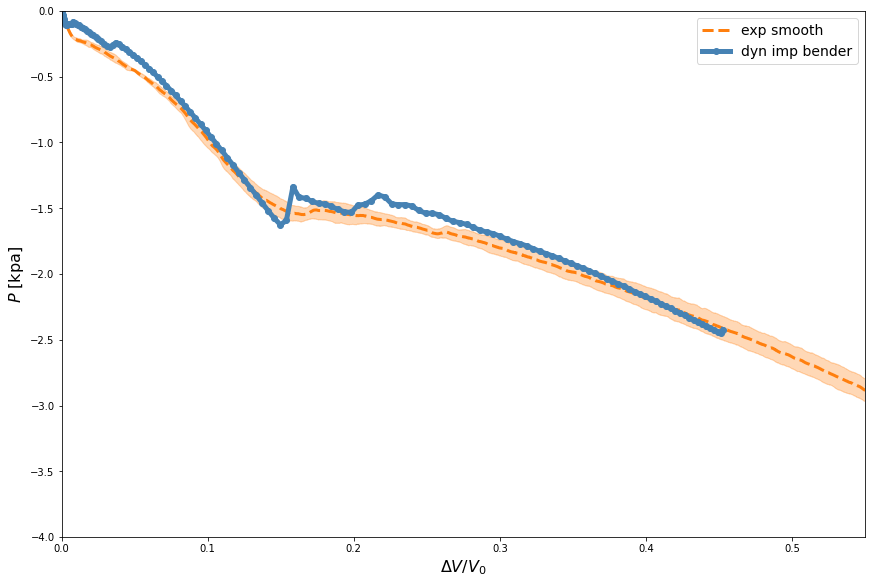

In [5]:
fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)

# ax.plot(vol_bend, pressure_bend, '--', linewidth = 3, color = 'goldenrod', label = 'exp')

ax.plot(vol_bend, pressure_bend_smooth_mean, '--', linewidth = 3, color = 'tab:orange', label = 'exp smooth')
ax.fill_between(vol_bend, pressure_bend_smooth_mean - pressure_bend_smooth_std, pressure_bend_smooth_mean + pressure_bend_smooth_std, color = 'tab:orange', alpha = 0.3)

idx_cur = 141
data_cur = np.loadtxt(f'data_out/bender-dyn-imp-v{idx_cur}_pcav_cvol.txt')
# data_cur = np.loadtxt(f'data_out/4fold-fitting-{idx_cur}_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3
print(data_cur[0,0])

ax.plot(vol_norm,pressure_kpa, '-o', label = 'dyn imp bender', color = 'steelblue', linewidth = 5)

idx_cur = 142
data_cur = np.loadtxt(f'data_out/bender-dyn-imp-v{idx_cur}_pcav_cvol.txt')
# data_cur = np.loadtxt(f'data_out/4fold-fitting-{idx_cur}_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3
print(data_cur[0,0])

# ax.plot(vol_norm,pressure_kpa, '-o', label = 'dyn imp bender 70 deg', color = 'deepskyblue', linewidth = 5)


ax.legend(loc = 'best', fontsize = 14)
ax.set_xlabel('$\Delta V/V_0$', fontsize = 16)
ax.set_ylabel('$P$ [kpa]', fontsize = 16)
ax.set_xlim(0,0.55)
ax.set_ylim(-4,0)

fig.savefig('scream yi/bender_pv_compare.png', facecolor = 'white')

print(vol_norm[[44,79,136]])

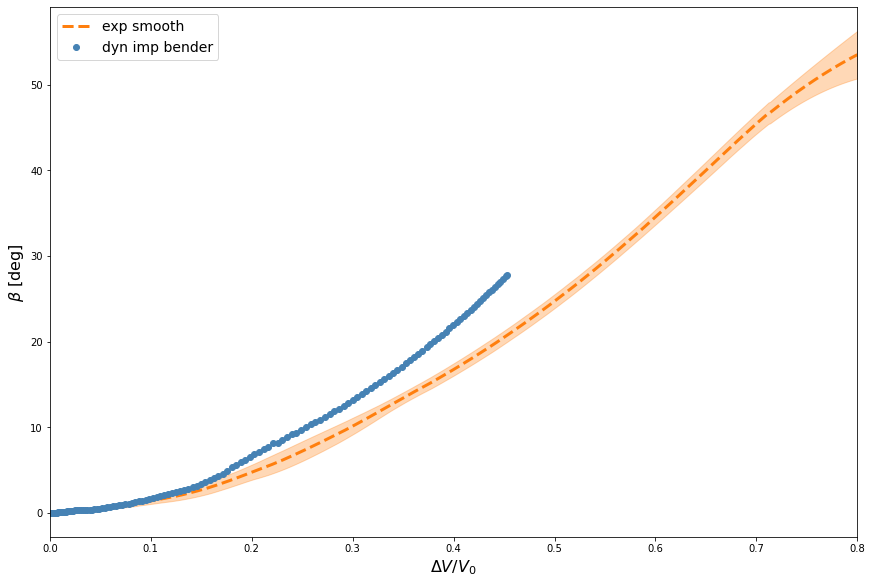

In [27]:
fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)

# ax.plot(vol_bend_ba, ba_bend, '--', linewidth = 3, color = 'goldenrod', label = 'exp')

ax.plot(vol_bend_ba, ba_smooth_mean, '--', linewidth = 3, color = 'tab:orange', label = 'exp smooth')
ax.fill_between(vol_bend_ba, ba_smooth_mean - ba_smooth_std, ba_smooth_mean + ba_smooth_std, color = 'tab:orange', alpha = 0.3)

idx_cur = 141
cvol, pcav = np.loadtxt(f'data_out/bender-dyn-imp-v{idx_cur}_pcav_cvol.txt', unpack = True)
bending_angle = np.loadtxt(f'data_out/bender-dyn-imp-v{idx_cur}_bending_angle.txt')
# data_cur = np.loadtxt(f'data_out/4fold-fitting-{idx_cur}_pcav_cvol.txt')
vol_norm = -(cvol - cvol[0])/cvol[0]


ax.plot(vol_norm, bending_angle * 180/np.pi, 'o', label = 'dyn imp bender', color = 'steelblue', linewidth = 5)


ax.legend(loc = 'best', fontsize = 14)
ax.set_xlabel('$\Delta V/V_0$', fontsize = 16)
ax.set_ylabel(r'$\beta$ [deg]', fontsize = 16)
ax.set_xlim(0,0.8)
# ax.set_ylim(-4,0)
fig.savefig('scream yi/bender_ba_compare.png', facecolor = 'white')

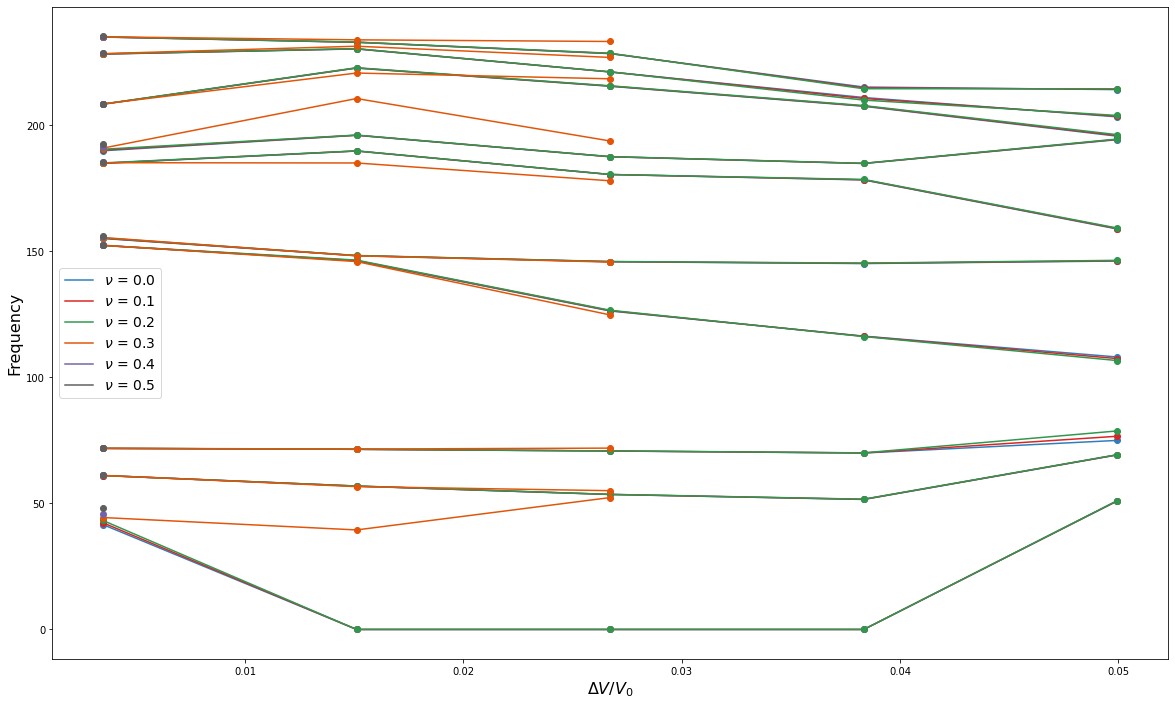

In [9]:
'''old nonsense'''
nu_try = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# fig, ax = plt.subplots(figsize = (14,10))
fig, ax = plt.subplots(figsize = (20,12))

initial_idx = 410

cmap_all = ['Blues', 'Reds','Greens', 'Oranges', 'Purples', 'Greys', 'BuGn', 'YlOrBr', 'PuRd']

for i,nu in enumerate(nu_try):
    if nu >= 0.0:
        idx_cur = initial_idx + i
        data_path = f'data_out/bender-test_nu-{idx_cur}_eig_freq.txt'
        data_cur = np.loadtxt(data_path)
        temp_all = data_cur[:,0]
        freq_all = data_cur[:,1:]

        color_plot = plt.get_cmap(cmap_all[i])(0.7)

        for j in range(np.shape(freq_all)[1]):
            ax.plot(-3*temp_all, freq_all[:,j], 'o', color = color_plot)
            if j == 0:
                ax.plot(-3*temp_all, freq_all[:,j], '-', color = color_plot, label = rf'$\nu$ = {nu}')
            else:
                ax.plot(-3*temp_all, freq_all[:,j], '-', color = color_plot)



ax.legend(loc = 'best', fontsize = 14)
ax.set_xlabel('$\Delta V/V_0$', fontsize = 16)
ax.set_ylabel('Frequency', fontsize = 16)


fig.savefig('data_processed/change_nu_bender_freq.jpg')
